## Functions to identify winners and filter only for races we have winners

---
- Only requires the candidate files
- Uses the 'Incumbent' tag from subsequent race to identfy winner in current race (assumes they run again, data leakage)
- Filter out races in years we don't have an identified winner from method above

In [3]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [4]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

### Step 1: Load in the multi-year candidate files

In [5]:
def parse_file(file_name, file_header):
    '''Tool to load in an FEC file with associated header and produce a Spark Dataframe'''   

    #load data frame and split by delimiter  
    df_temp = sc.textFile(file_name).map(lambda row: [elem for elem in row.split('|')])
    
    #load separate header csv file and prepare schema 
    #assumes all values are STRING TYPE for simplicity
    head_temp = pd.read_csv(file_header)
    fields = [*[typ.StructField(h[:], typ.StringType(), True) for h in head_temp.columns]]
    schema = typ.StructType(fields)
    
    #finalize spark dataframe
    df = spark.createDataFrame(df_temp, schema)
    
    return df

In [6]:
#Taking all of the candidate files, reading them through parse_file and joining into a single table

#df_candidate_20 = parse_file('candidate_2020.txt', 'candidate_header_file.csv')
#df_candidate_18 = parse_file('candidate_2018.txt', 'candidate_header_file.csv')
#df_candidate_16 = parse_file('candidate_2016.txt', 'candidate_header_file.csv')


#updated based on the file structure in the repo
df_candidate_20 = parse_file('./fec_data/cn/cn20.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_18 = parse_file('./fec_data/cn/cn18.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_16 = parse_file('./fec_data/cn/cn16.txt', './fec_data/cn/cn_header_file.csv')


dfs = [df_candidate_20, df_candidate_18, df_candidate_16]

df_candidate = reduce(DataFrame.unionAll, dfs)

#converting to a pandas DF for ease of working with
df_candidate = df_candidate.select('*').toPandas() 

In [7]:
len(df_candidate)

22275

### Step 2: Identify WINNERS in a race

In [8]:
def identify_candidates(df, year_race, year_incumbent):
    '''
    df = dataframe, created in the step above
    year_race = string, year of the actual race where we will identify the winner (e.g., '2018')
    year_incumbent = string, election year AFTER the actual race where winner will be incumbent (e.g., '2020')    
    
    output is dataframe
    '''
    ##WINNERS
    #identify the incumbents based on year and identifier 'I' = incumbent in the documentation
    df_winners = df[(df.CAND_ELECTION_YR == year_incumbent) & (df.CAND_ICI == 'I') & (df.CAND_OFFICE != 'P')]
    #there are duplicates listed based on certain changes in status, but we only care about the unique candidate IDs who are incumbents
    df_winners = df_winners.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)
    
    
    ##CANDIDATE
    #identify the pool of candidates in the year of the actual race
    df_candidates = df[(df.CAND_ELECTION_YR == year_race)&(df.CAND_OFFICE != 'P')]
    #same issue with duplicates
    df_candidates = df_candidates.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)
    
    
    ##MATCHING WINNERS TO CANDIDATES
    #naming issues between years, use FUZZYWUZZY to match name strings from winner, candidate DFs
    df_candidates['WINNER'] = 0

    for name in df_candidates.CAND_NAME:
        ratio = process.extract(name, df_winners.CAND_NAME, limit = 1, scorer=fuzz.token_set_ratio)
          
        #if the match is deemed 100% (typically due to just periods, abbreviations), consider them a winner
        if ratio[0][1] == 100:
            df_candidates.loc[(df_candidates['CAND_NAME'] == name),'WINNER'] = 1
    
    ##FILTERING CANDIDATES
    #steps to filter out races we don't have a winner; use the unique office position to filter
    df_candidates['OFFICE_CONCAT'] = df_candidates['CAND_OFFICE_ST']+df_candidates['CAND_OFFICE']+df_candidates['CAND_OFFICE_DISTRICT']
    office_list = [office for office in df_candidates.loc[df_candidates['WINNER'] == 1].OFFICE_CONCAT.unique()]
    
    df_final = df_candidates.loc[df_candidates['OFFICE_CONCAT'].isin(office_list)]
    
    return df_final
    

In [9]:
df_2018 = identify_candidates(df_candidate, '2018', '2020')

In [10]:
df_2018.groupby('OFFICE_CONCAT').count()

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP,WINNER
OFFICE_CONCAT,,,,,,,,,,,,,,,,
AKH00,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
ALH01,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
ALH02,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
ALH03,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
ALH04,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WIH08,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
WVH01,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
WVH02,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### Step 3: CONCATENATE Multiple Years of Data

In [11]:
temp_df2018 = identify_candidates(df_candidate,'2018','2020')
temp_df2016 = identify_candidates(df_candidate,'2016','2018')

df_combined = pd.concat([temp_df2016,temp_df2018])

In [12]:
df_combined.head()

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP,WINNER,OFFICE_CONCAT
0,H0CA15148,"HONDA, MIKE",DEM,2016,CA,H,17,I,P,C00351379,"C/O CONTRIBUTION SOLUTIONS, LLC","1346 THE ALAMEDA, STE. 7-380",SAN JOSE,CA,95126,0,CAH17
1,H0CT02140,"NOVAK, DARIA IRENE",REP,2016,CT,H,02,C,P,C00589713,51 HAMMONASSETT MEADOWS ROAD,,MADISON,CT,06443,0,CTH02
2,H0DE01017,"CARNEY, JOHN",DEM,2016,DE,H,00,I,P,C00460899,P.O. BOX 2162,,WILMINGTON,DE,19899,0,DEH00
3,H0FL04033,"PUESCHEL, DEBORAH KATZ",W,2016,FL,H,04,O,N,C00346767,7645 SENTRY OAK CIRCLE EAST,,JACKSONVILLE,FL,32256,0,FLH04
4,H0FL04066,"CRENSHAW, ANDER",REP,2016,FL,H,04,I,P,C00352849,7235 BONNEVAL RD,SUITE 228,JACKSONVILLE,FL,322567506,0,FLH04


In [13]:
df_combined.WINNER.sum()

867

In [14]:
len(df_combined)

5517

---
### Plotly Choropleth Maps:  
https://plotly.com/python/choropleth-maps/

In [15]:
import plotly.graph_objects as go
import pandas as pd

In [16]:
states_x50 = ['AS','DC','GU','PR','MP','VI']
temp_df = df_combined[['CAND_OFFICE_ST','CAND_ID']].groupby('CAND_OFFICE_ST').count().reset_index()
temp_df = temp_df[~temp_df.CAND_OFFICE_ST.isin(states_x50)]

In [17]:
temp_df

,CAND_OFFICE_ST,CAND_ID
0,AK,20
1,AL,62
2,AR,38
4,AZ,181
5,CA,517
6,CO,101
7,CT,45
9,DE,21
10,FL,386
11,GA,135


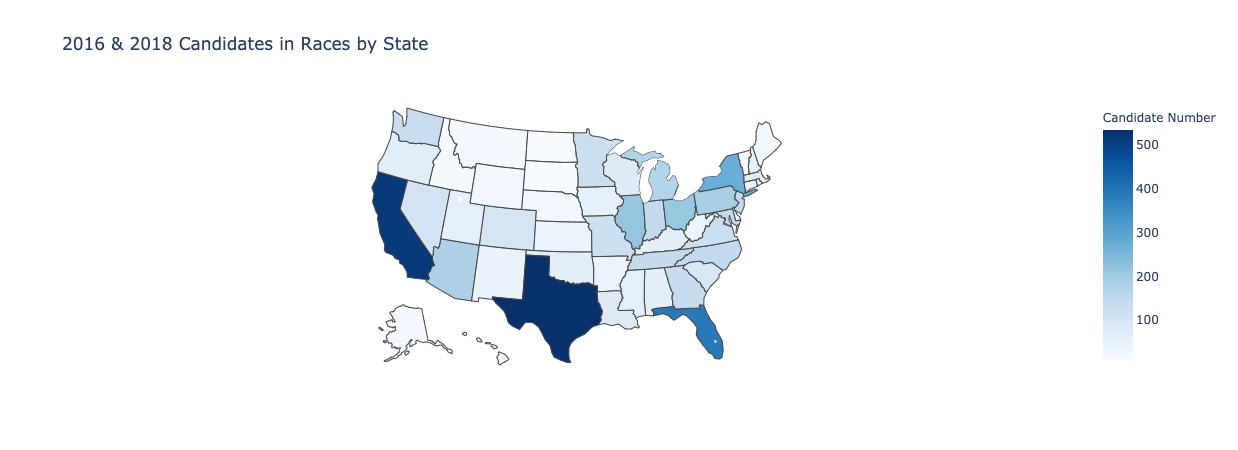

In [23]:
fig = go.Figure(data=go.Choropleth(
    locations=temp_df.CAND_OFFICE_ST, # Spatial coordinates
    z = temp_df.CAND_ID, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Candidate Number",
))

fig.update_layout(
    title_text = '2016 & 2018 Candidates in Races by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()